# Credit Card Fraud Detection

The goal of this notebook is to be able to identify fraudulent credit card transactions. The dataset used was found on Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud) and contains transactions made by credit cards in Sept 2013 by european cardholders. This data set only contains numerical input variables which are a result of a PCA transformation. Due to confidentiality issues, the names of the original features and background information about the data is not shown. 

The work of this notebook was a learning experience on how to deal with an imbalanced dataset, drawing from solutions from other notebooks such as from: 


In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, auc, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
import warnings
warnings.filterwarnings("ignore")

## Data Exploration

In this section, we will import the dataset and see what the data looks like. 

In [2]:
raw_data = pd.read_csv('creditcard.csv')
raw_data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
raw_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
raw_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Based on the source of this dataset, many columns were renamed and rescaled via PCA as they contain confidential information. The only known features are Time and Amount. Class is used to identify whether a transaction was fraud. 

In [5]:
raw_data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
raw_data['Class'].count()

284807

We can see that the amount of non-fraud transaction heavily outnumber those that were actual fraud transactions. It is clear that this is an unbalanced dataset

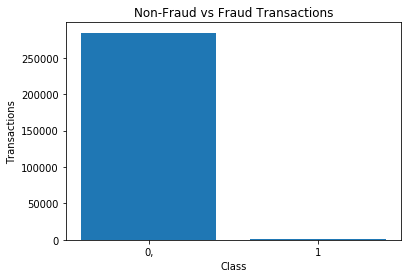

In [7]:
# Plotting count of non-fraud vs fraud transactions
objects = ('0,', '1')
plt.bar(raw_data['Class'].unique(), raw_data['Class'].value_counts())
plt.title('Non-Fraud vs Fraud Transactions')
plt.xticks(raw_data['Class'].unique(), objects)
plt.ylabel('Transactions')
plt.xlabel('Class')
plt.show()

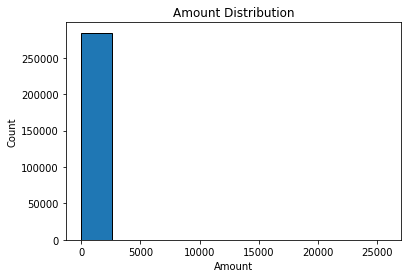

In [8]:
plt.hist(raw_data['Amount'], edgecolor='black')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.title('Amount Distribution')
plt.show()

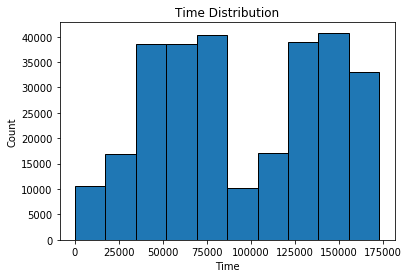

In [9]:
plt.hist(raw_data['Time'], edgecolor='black')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Time Distribution')
plt.show()

In [10]:
# Need to scale time and amount to be close to the range of the other features

standard_scaler = StandardScaler()
robust_scaler = RobustScaler() # used for outliers - applicable to Time

# reshape(-1,1) ensures that the shape is compatible with the original shape
raw_data['Scaled_Time'] = robust_scaler.fit_transform(raw_data['Time'].values.reshape(-1,1))
raw_data['Scaled_Amount'] = standard_scaler.fit_transform(raw_data['Amount'].values.reshape(-1,1))

In [11]:
# Drop old raw_data Time and Amount
raw_data.drop(['Time', 'Amount'], axis=1, inplace=True)

In [12]:
raw_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_Time,Scaled_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-0.994983,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.994983,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-0.994972,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-0.994972,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.994960,-0.073403


## Random Under Sampling

We need to create a subset of data which contains a balanced set containing both fraud and non-fraud transactions. For this, we will use Random under-sampling. We will do this by matching the non-fraud transactions to be the same as the number of fraud transactions. 

The trade-off for doing this is that we might lose a lot of information since we are decreasing the non-fraud transactions down to 492. 

In [13]:
shuffled_data = raw_data.sample(frac = 1, random_state = 1)

In [14]:
fraud_data = shuffled_data.loc[shuffled_data['Class'] == 1]

In [15]:
non_fraud_data = shuffled_data.loc[shuffled_data['Class'] == 0][:shuffled_data['Class'].value_counts()[1]]

In [16]:
balanced_data = pd.concat([fraud_data, non_fraud_data])

balanced_data = balanced_data.sample(frac = 1, random_state = 1)

In [17]:
balanced_data['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

In [18]:
balanced_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_Time,Scaled_Amount
125314,-1.253215,1.758471,1.719816,2.708741,-0.056567,1.529020,-0.864988,-3.102803,-0.192266,1.235317,...,-0.422691,0.061007,-0.465925,-0.128512,0.398483,0.462971,-0.000662,0,-0.083166,-0.267910
96341,1.227614,-0.668974,-0.271785,-0.589440,-0.604795,-0.350285,-0.486365,-0.010809,-0.794944,0.264545,...,-0.295255,-0.180459,-0.436539,0.494649,-0.283738,-0.001128,0.035075,1,-0.222794,0.038623
248296,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,-4.230984,...,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,1,0.812780,-0.353229
90956,0.994100,-0.449771,-0.045731,-0.582983,-0.786465,-0.874566,-0.172380,-0.016904,1.327152,-1.406480,...,0.086370,-0.230433,0.246285,0.591999,-0.653492,0.058589,0.061649,0,-0.251918,0.118865
21096,-0.678124,-0.186876,2.989155,0.424337,-0.458720,1.996461,-0.369584,0.403119,0.982392,-0.590724,...,0.769421,-0.440813,-0.899838,0.423146,0.883422,-0.072178,-0.155181,0,-0.625372,-0.038980


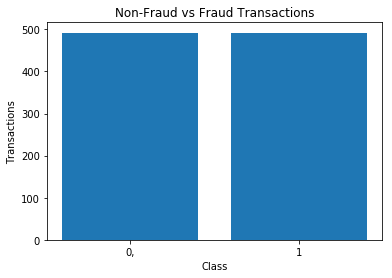

In [19]:
# Plotting count of non-fraud vs fraud transactions
objects = ('0,', '1')

plt.bar(balanced_data['Class'].unique(), balanced_data['Class'].value_counts())
plt.title('Non-Fraud vs Fraud Transactions')
plt.xticks(balanced_data['Class'].unique(), objects)
plt.ylabel('Transactions')
plt.xlabel('Class')
plt.show()

With a balanced dataset via random undersampling, we can look into the correlations between each feature with respect to the output class. 

In [20]:
# Correlation matrix of the balanced data set
corr_balanced_data = balanced_data.corr()

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

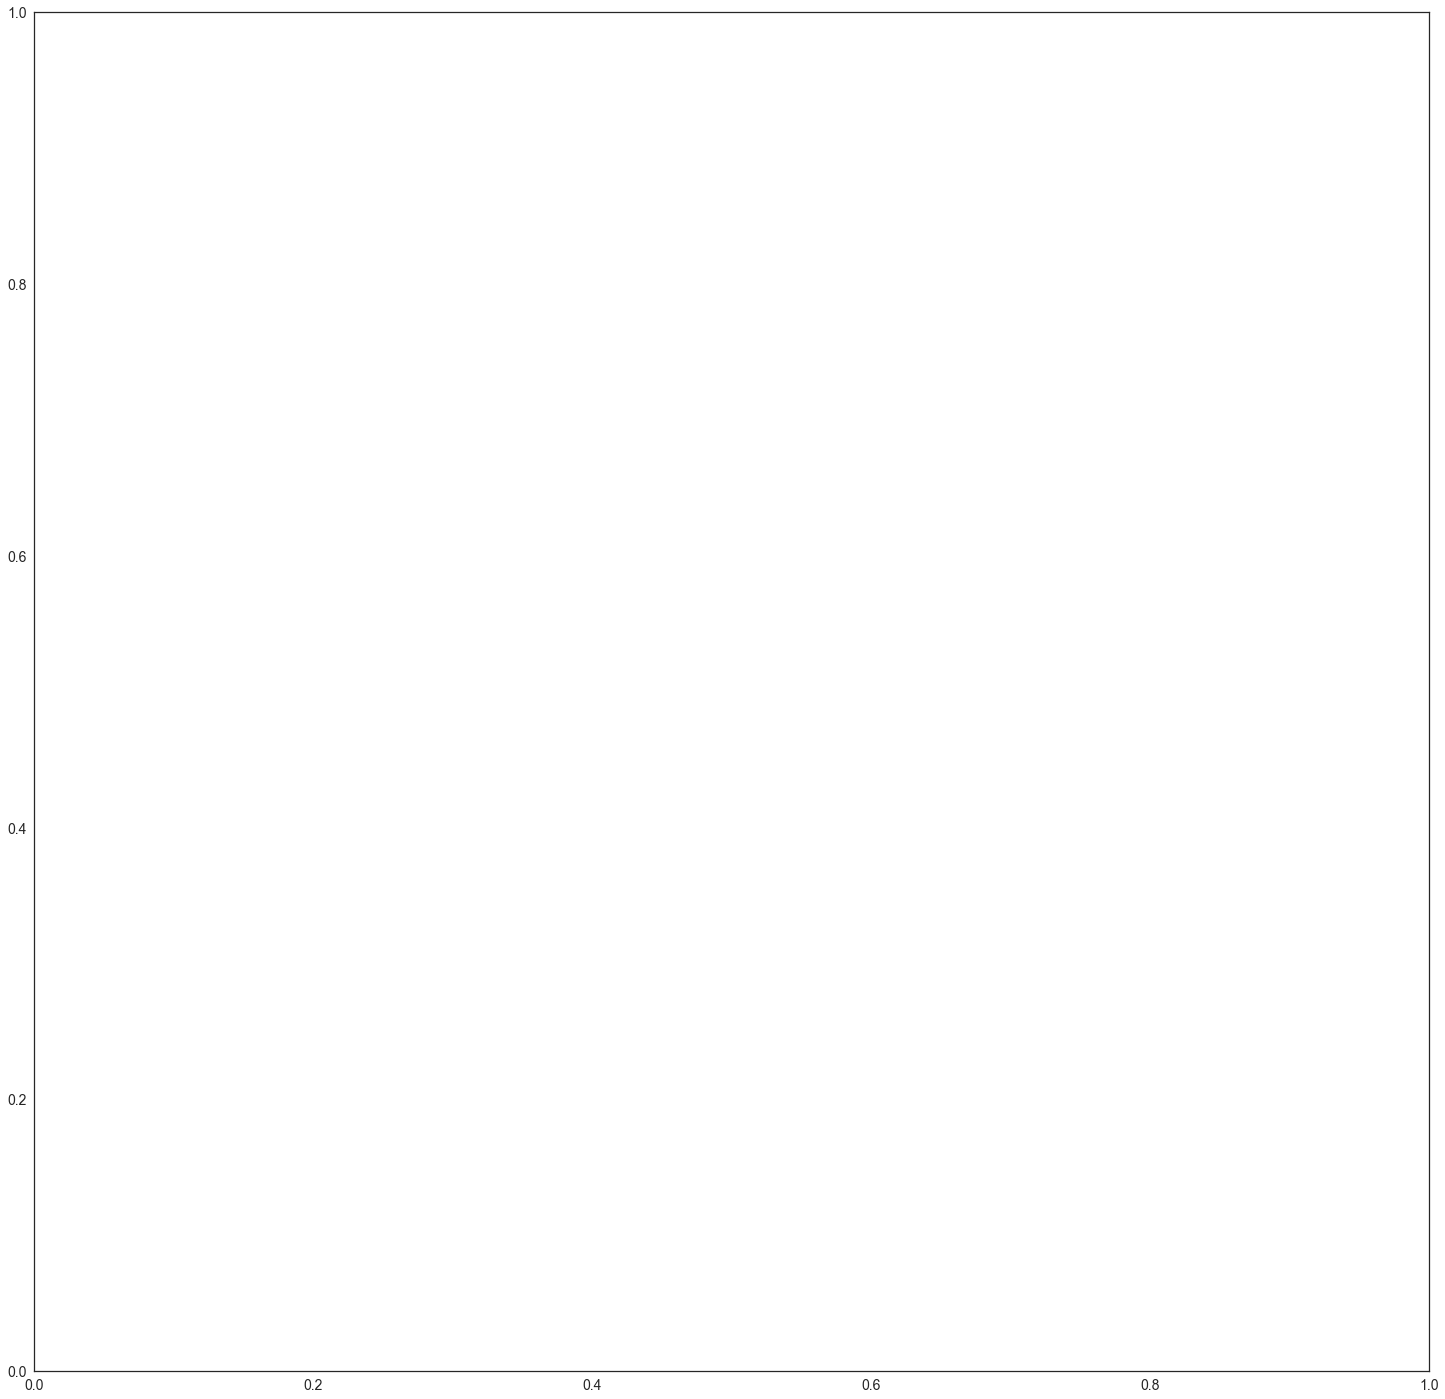

In [22]:
sns.set(style="white", font_scale=1.4)
mask = np.zeros_like(corr_balanced_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_balanced_data, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
corr_class = corr_balanced_data['Class']
indices_class = corr_balanced_data['Class'].index

features = []
value_corr_features = []

for value, index in zip(corr_class, indices_class):
    if abs(value) > 0.2:
        features.append(index)
        value_corr_features.append(value)

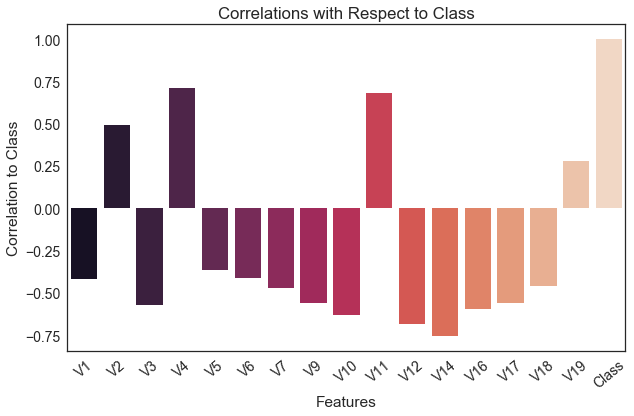

In [24]:
plt.figure(figsize=(10,6))
ax=sns.barplot(x=features, y=value_corr_features, palette="rocket")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.title('Correlations with Respect to Class')
plt.xlabel('Features')
plt.ylabel('Correlation to Class')
plt.show()

By inspection, we can see that the fraudulent transaction has a positive correlaton with features V4, V11, V2, and V19 while it has negative correlation with V14, V12, V10 and V16. While it is clear that other features have a negative correlation with the class, we will be looking into the listed features as they have the higher correlation with the class. As such, we will need to remove outliers from these features as they will have an impact on the accuracy of the machine learning models. 

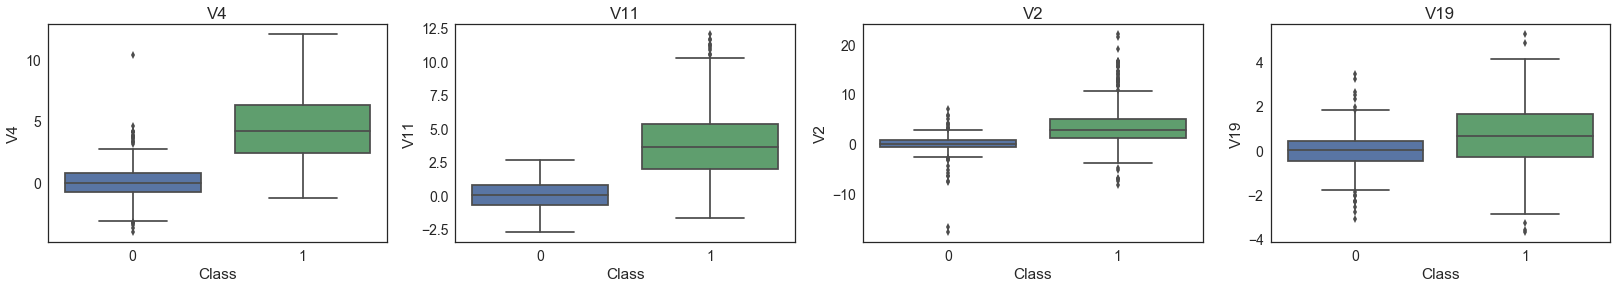

In [25]:
# Let's see if there are any outliers on the listed features. 
f, axes = plt.subplots(ncols=4, figsize=(28,4))
# Positive features
sns.boxplot(x="Class", y="V4", data=balanced_data, ax=axes[0])
axes[0].set_title('V4')
sns.boxplot(x="Class", y="V11", data=balanced_data, ax=axes[1])   
axes[1].set_title('V11')
sns.boxplot(x="Class", y="V2", data=balanced_data, ax=axes[2]) 
axes[2].set_title('V2')
sns.boxplot(x="Class", y="V19", data=balanced_data, ax=axes[3])   
axes[3].set_title('V19')
plt.show()

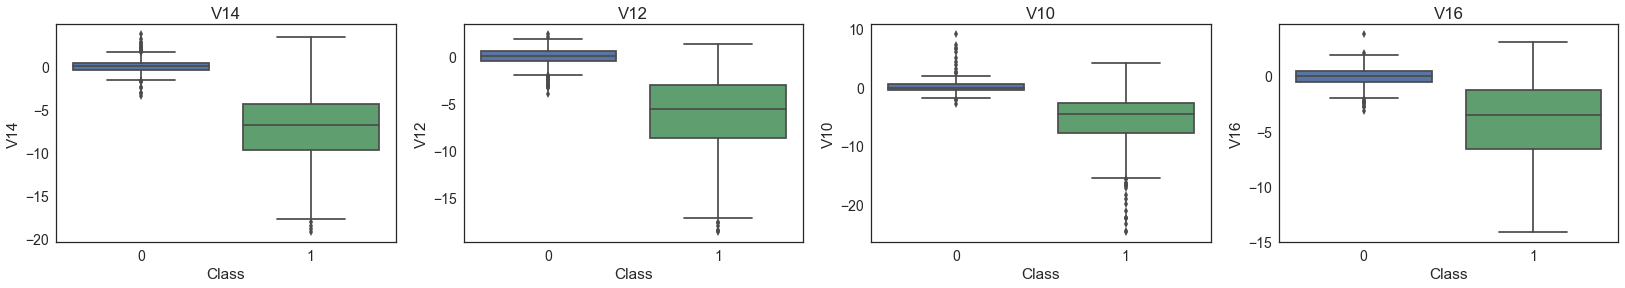

In [26]:
f, axes = plt.subplots(ncols=4, figsize=(28,4))
# Positive features
sns.boxplot(x="Class", y="V14", data=balanced_data, ax=axes[0])
axes[0].set_title('V14')
sns.boxplot(x="Class", y="V12", data=balanced_data, ax=axes[1])   
axes[1].set_title('V12')
sns.boxplot(x="Class", y="V10", data=balanced_data, ax=axes[2]) 
axes[2].set_title('V10')
sns.boxplot(x="Class", y="V16", data=balanced_data, ax=axes[3])   
axes[3].set_title('V16')
plt.show()

Based on the box plots, there exists multiple outliers beyond the 25th and 75th percentiles. We determine the threshold for removing outliers by multiplying a number by the interquartile range. The higher this threshold, the less outliers it will detect. The lower the threshold, the more outliers it will detect. 

We want to focus on removing extreme outliers instead of general outliers as we might run into the risk of losing information. 

The code below shows an example of playing around with the cutoff range for the negative correlation between V2 and the output class. 

In [27]:
# Play with cut off values to determine which to cut off
V2_fraud = balanced_data['V2'].loc[balanced_data['Class'] == 0].values
V2_q25 = np.percentile(V2_fraud, 25)
V2_q75 = np.percentile(V2_fraud, 75)
V2_iqr = V2_q75 - V2_q25

V2_cut_off = V2_iqr * 3
V2_lower = V2_q25 - V2_cut_off
V2_upper = V2_q75 + V2_cut_off

V2_outliers = []

for data in V2_fraud:
    if (data < V2_lower or data > V2_upper):
        V2_outliers.append(data)
print(len(V2_outliers))


12


To apply this easily to other features, I wrote a function to do this given a specific feature and cutoff multiplier. 

In [28]:
# Create a function to remove outliers based on cutoff
def remove_outliers(dataframe, feature, fraud_class, cutoff):
    feature_data = dataframe[feature].loc[dataframe['Class'] == fraud_class].values
    feature_q25 = np.percentile(feature_data, 25)
    feature_q75 = np.percentile(feature_data, 75)
    feature_iqr = feature_q75 - feature_q25
    
    feature_cut_off = feature_iqr * cutoff
    feature_lower = feature_q25 - feature_cut_off
    feature_upper = feature_q75 + feature_cut_off
    
    feature_outliers = []

    for data in feature_data:
        if (data < feature_lower or data > feature_upper):
            feature_outliers.append(data)
    # print("Found {} outliers".format(len(feature_outliers)))
    df = dataframe.drop(dataframe[(dataframe[feature] > feature_upper) | (dataframe[feature] < feature_lower)].index)
    return df

In [29]:
# Use function to print and see how many outliers were removed
# test = remove_outliers(balanced_data, 'V16', 0, 1.85)

In [30]:
# Play around with the cut off and then plot them on a box plot. 
#balanced_data = remove_outliers(balanced_data, 'V4', 0, 3)
#balanced_data = remove_outliers(balanced_data, 'V2', 0, 3)
balanced_data = remove_outliers(balanced_data, 'V2', 1, 4)
balanced_data = remove_outliers(balanced_data, 'V10', 1, 4)
balanced_data = remove_outliers(balanced_data, 'V12', 1, 4)
#balanced_data = remove_outliers(balanced_data, 'V16', 0, 3)

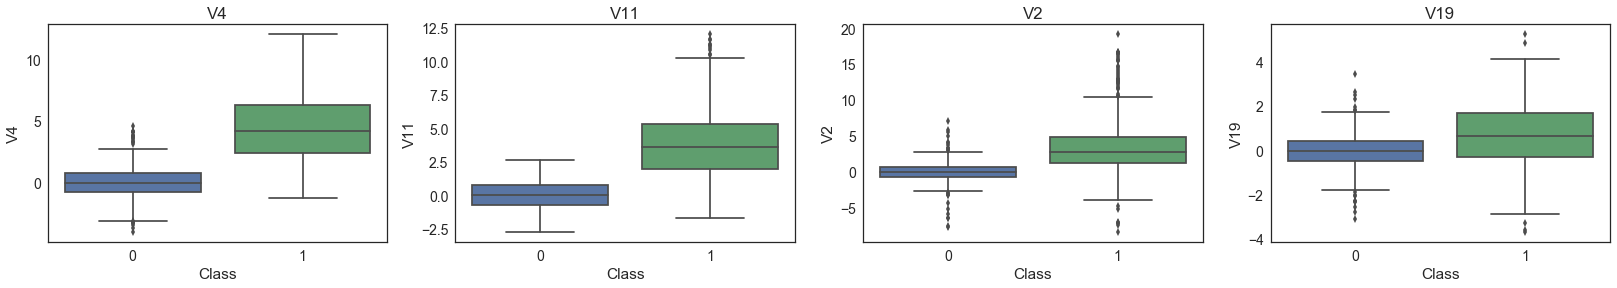

In [31]:
# Let's see if there are any outliers on the listed features. 
f, axes = plt.subplots(ncols=4, figsize=(28,4))
# Positive features
sns.boxplot(x="Class", y="V4", data=balanced_data, ax=axes[0])
axes[0].set_title('V4')
sns.boxplot(x="Class", y="V11", data=balanced_data, ax=axes[1])   
axes[1].set_title('V11')
sns.boxplot(x="Class", y="V2", data=balanced_data, ax=axes[2]) 
axes[2].set_title('V2')
sns.boxplot(x="Class", y="V19", data=balanced_data, ax=axes[3])   
axes[3].set_title('V19')
plt.show()

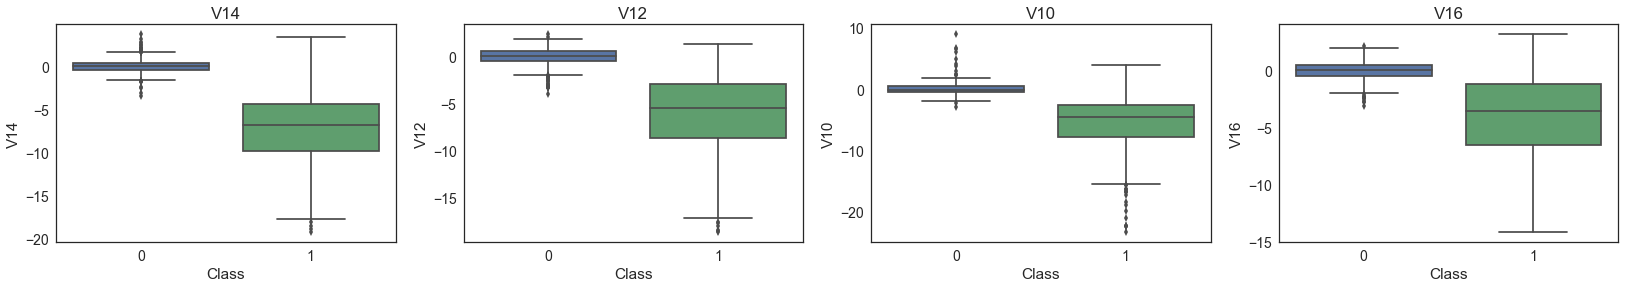

In [32]:
f, axes = plt.subplots(ncols=4, figsize=(28,4))
# Positive features
sns.boxplot(x="Class", y="V14", data=balanced_data, ax=axes[0])
axes[0].set_title('V14')
sns.boxplot(x="Class", y="V12", data=balanced_data, ax=axes[1])   
axes[1].set_title('V12')
sns.boxplot(x="Class", y="V10", data=balanced_data, ax=axes[2]) 
axes[2].set_title('V10')
sns.boxplot(x="Class", y="V16", data=balanced_data, ax=axes[3])   
axes[3].set_title('V16')
plt.show()

We can visually see that there are fewer outliers for the selected features that we modified.

## Clustering

After removing extreme outliers, we will use t-SNE and PCA to see if we can accurately cluster the cases that were fraud and non-fraud. 

In [33]:
X = balanced_data.drop('Class', axis = 1) # random undersampled dataset inputs
y = balanced_data['Class'] # random undersampled dataset outputs

t_SNE_model = TSNE(n_components=2, random_state = 1)
X_tsne = t_SNE_model.fit_transform(X)

t_PCA_model = PCA(n_components=2, random_state = 1)
X_PCA = t_PCA_model.fit_transform(X)

[]

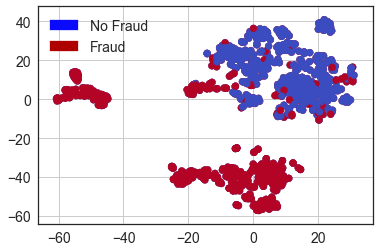

In [34]:
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

plt.scatter(X_tsne[:,0],X_tsne[:,1], c=(y==0), cmap='coolwarm', label='No Fraud')
plt.scatter(X_tsne[:,0],X_tsne[:,1], c=(y==1), cmap='coolwarm', label='No Fraud')
plt.legend(handles=[blue_patch, red_patch])
plt.grid(True)
plt.plot()


[]

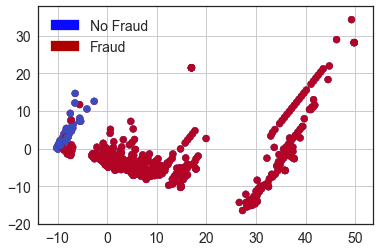

In [35]:
plt.scatter(X_PCA[:,0],X_PCA[:,1], c=(y==0), cmap='coolwarm', label='No Fraud')
plt.scatter(X_PCA[:,0],X_PCA[:,1], c=(y==1), cmap='coolwarm', label='No Fraud')
plt.legend(handles=[blue_patch, red_patch])
plt.grid(True)
plt.plot()


We can see that for both t-SNE and PCA, the fraud and non-fraud datapoints are seen clustered close together with some overlapping points. 

# Model Implementation - Random Undersampling

In this section, we will use the random under sampling balanced dataset to train a logistic regression model and a kNN model. We will then use kfold and take the average to see how it performs compared to each other. 

In [36]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Logistic Regression

We will first train a generic logistic regression model and then use kFold to determine its accuracy/metrics across multiple folds. 

In [37]:
# Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
train_score = cross_val_score(log_model, X_train, y_train, cv = 5)
print(train_score.mean()) #training score mean

0.9438592193369264


In [38]:
pred_log = log_model.predict(X_test)

In [39]:
print('Accuracy: %.2f%%' % (accuracy_score(y_test, pred_log)*100))

Accuracy: 94.90%


In [40]:
# Print classification report
print(classification_report(y_test,pred_log))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        84
           1       0.96      0.95      0.95       112

    accuracy                           0.95       196
   macro avg       0.95      0.95      0.95       196
weighted avg       0.95      0.95      0.95       196



In [41]:
# Get Confusion Matrix
cnf_matrix_log = confusion_matrix(y_test, pred_log)
# print (cnf_matrix_log)
class_names = balanced_data['Class'].unique()
class_names_label = [0, 1]

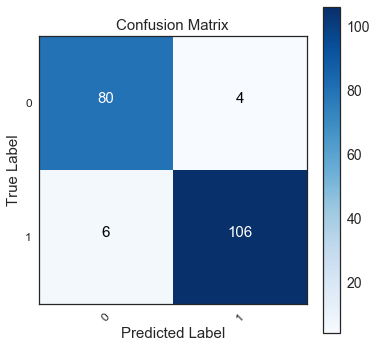

In [42]:
plt.figure(figsize=(6,6))
plt.imshow(cnf_matrix_log, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names_label, rotation=45, fontsize=12)
plt.yticks(tick_marks, class_names_label, fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)


for i in range(len(cnf_matrix_log)):
    for j in range(len(cnf_matrix_log[i])):
        color = 'black'   
        if cnf_matrix_log[i][j] > 50:
            color = 'white'
        plt.text(j, i, format(cnf_matrix_log[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

Area under the ROC curve: 0.949405


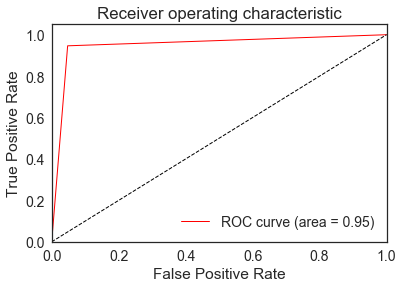

In [43]:
# ROC curve - plot True Positive Rate against False Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, pred_log)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve: %f" % roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [44]:
# Define function to help run kfold on the models

def run_kfold(X, Y, model):
    kf = KFold(n_splits=10)
    
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    auc_list = []
    fold = 0
    
    for train_index, test_index in kf.split(X, Y):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = accuracy_score(Y_test, predictions)
        precision = precision_score(Y_test, predictions)
        recall = recall_score(Y_test, predictions)
        f1 = f1_score(Y_test, predictions)
        auc = roc_auc_score(Y_test, predictions)
        
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        auc_list.append(auc)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
       
    return np.mean(accuracy_list), np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), np.mean(auc_list)



In [45]:
log_model_kFold = LogisticRegression()
acc_log, prec_log, recall_log, f1_log, auc_log = run_kfold(X, y, log_model_kFold)
print("--"*42) 
print("Accuracy: {0}".format(acc_log))  
print("Precision: {0}".format(prec_log))  
print("Recall: {0}".format(recall_log))  
print("F1: {0}".format(f1_log))  
print("AUC: {0}".format(auc_log))  

Fold 1 accuracy: 0.9489795918367347
Fold 2 accuracy: 0.9285714285714286
Fold 3 accuracy: 0.9591836734693877
Fold 4 accuracy: 0.9387755102040817
Fold 5 accuracy: 0.9591836734693877
Fold 6 accuracy: 0.9387755102040817
Fold 7 accuracy: 0.9591836734693877
Fold 8 accuracy: 0.9285714285714286
Fold 9 accuracy: 0.9591836734693877
Fold 10 accuracy: 0.9795918367346939
------------------------------------------------------------------------------------
Accuracy: 0.95
Precision: 0.97449519894448
Recall: 0.9247845932006008
F1: 0.9485246131220532
AUC: 0.950171575966856


## K-Nearest Neighbour - Random Undersampling

In this section, we will be using the same approach taken on logistic regression using the random undersampling method. 

In [46]:
# kNN
kNN_model = KNeighborsClassifier()
kNN_model.fit(X_train, y_train)
train_score = cross_val_score(kNN_model, X_train, y_train, cv = 5) # training score

In [47]:
pred_kNN = kNN_model.predict(X_test)

In [48]:
print('Accuracy: %.2f%%' % (accuracy_score(y_test, pred_kNN)*100))

Accuracy: 95.92%


In [49]:
# Print classification report
print(classification_report(y_test,pred_kNN))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95        84
           1       0.99      0.94      0.96       112

    accuracy                           0.96       196
   macro avg       0.96      0.96      0.96       196
weighted avg       0.96      0.96      0.96       196



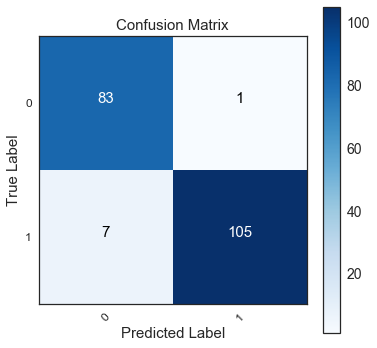

In [50]:
# Get Confusion Matrix
cnf_matrix_kNN = confusion_matrix(y_test, pred_kNN)

plt.figure(figsize=(6,6))
plt.imshow(cnf_matrix_kNN, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names_label, rotation=45, fontsize=12)
plt.yticks(tick_marks, class_names_label, fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)


for i in range(len(cnf_matrix_kNN)):
    for j in range(len(cnf_matrix_kNN[i])):
        color = 'black'   
        if cnf_matrix_kNN[i][j] > 50:
            color = 'white'
        plt.text(j, i, format(cnf_matrix_kNN[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

Area under the ROC curve: 0.962798


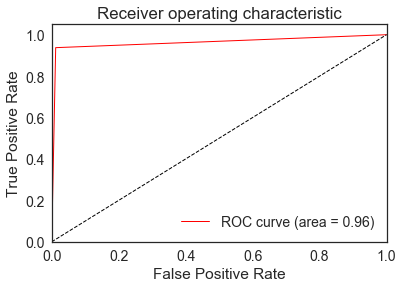

In [51]:
# ROC curve - plot True Positive Rate against False Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, pred_kNN)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve: %f" % roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [52]:
kNN_model_kFold = KNeighborsClassifier()
acc_kNN, prec_kNN, recall_kNN, f1_kNN, auc_kNN = run_kfold(X, y, kNN_model_kFold)
print("--"*42) 
print("Accuracy: {0}".format(acc_kNN))  
print("Precision: {0}".format(prec_kNN))  
print("Recall: {0}".format(recall_kNN))  
print("F1: {0}".format(f1_kNN))  
print("AUC: {0}".format(auc_kNN))  

Fold 1 accuracy: 0.9387755102040817
Fold 2 accuracy: 0.9183673469387755
Fold 3 accuracy: 0.9693877551020408
Fold 4 accuracy: 0.9183673469387755
Fold 5 accuracy: 0.9591836734693877
Fold 6 accuracy: 0.9183673469387755
Fold 7 accuracy: 0.9591836734693877
Fold 8 accuracy: 0.9387755102040817
Fold 9 accuracy: 0.9693877551020408
Fold 10 accuracy: 0.9387755102040817
------------------------------------------------------------------------------------
Accuracy: 0.9428571428571428
Precision: 0.9785122744750074
Recall: 0.9063655890500218
F1: 0.9406551757535414
AUC: 0.9428062242751615


### Compare logistic regression and KNearestNeighbours for Random Undersampling

In [54]:
print("\t\tLogistic Regression\t|\t\tKNN")
print("Accuracy:\t {0}\t|\t{1}".format(acc_log, acc_kNN))  
print("Precision:\t {0}\t|\t{1}".format(prec_log, prec_kNN))  
print("Recall:\t\t {0}\t|\t{1}".format(recall_log, recall_kNN))  
print("F1:\t\t {0}\t|\t{1}".format(f1_log, f1_kNN))  
print("AUC:\t\t {0}\t|\t{1}".format(auc_log, auc_kNN))  
print("--"*42)

		Logistic Regression	|		KNN
Accuracy:	 0.95	|	0.9428571428571428
Precision:	 0.97449519894448	|	0.9785122744750074
Recall:		 0.9247845932006008	|	0.9063655890500218
F1:		 0.9485246131220532	|	0.9406551757535414
AUC:		 0.950171575966856	|	0.9428062242751615
------------------------------------------------------------------------------------


We can see that both logistic regression and kNN achieved relatively high metrics in classifying fraudulent vs non-fraudulent transactions on the balanced dataset via random undersampling. While these accuracies and scores are already high, we can further improve this through tuning the parameters of the model. However, one main drawback of this dataset is that we undersampled and decreased the original size of the dataset in order to have a balanced dataset between the classes. As a result, we may have information loss from removing datapoints from our data set. We can further potentially increase our accuracies by using a technique called over sampling, which synthetically creates datapoints to balance our dataset. 

# Over Sampling

As mentioned before, we will balance the imbalanced dataset by synthetically producing new data poitns via oversampling. In order to do this, we will need to use the original dataset, resample it via SMOTE - Synthetic Minority Over-sampling Technique, using a library dedicated to dealing with imbalanced datasets. We will then perform the same type of model implementation as was shown in the random undersampling cases. 

In [55]:
X_orig = raw_data.drop(['Class'], axis=1)
y_orig = raw_data['Class']
smt = SMOTE(sampling_strategy = 'minority', random_state = 42)

# we want to perform train test split on the before we perform oversampling on the training set. 
# we should not perform oversampling on the test set as it is a problem of data leakage (i.e. modifying validation/test set)
X_smt_train, X_smt_test, y_smt_train, y_smt_test = train_test_split(X_orig, y_orig, test_size = 0.2, random_state = 1)
X_smt_sampled, y_smt_sampled = smt.fit_sample(X_smt_train, y_smt_train)

In [57]:
# print the length before and after oversampling
print("Length Before SMOTE: {0}".format(len(X_smt_train)))
print("Length After SMOTE: {0}".format(len(X_smt_sampled)))

Length Before SMOTE: 227845
Length After SMOTE: 454880


## Logistic Regression - Oversampling

In [56]:
# Logistic Regression
log_model_SMOTE = LogisticRegression()
log_model_SMOTE.fit(X_smt_sampled, y_smt_sampled)
train_score_SMOTE = cross_val_score(log_model_SMOTE, X_smt_sampled, y_smt_sampled, cv = 5)
print(train_score_SMOTE.mean()) #training score mean

0.9515410657755892


In [58]:
pred_log_smt = log_model_SMOTE.predict(X_smt_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_smt_test, pred_log_smt)*100))

Accuracy: 97.91%


In [59]:
# Print classification report
print(classification_report(y_smt_test,pred_log_smt))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56875
           1       0.06      0.89      0.11        87

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [60]:
# Get Confusion Matrix
cnf_matrix_log_smt = confusion_matrix(y_smt_test, pred_log_smt)
class_names = raw_data['Class'].unique()
class_names_label = [0, 1]

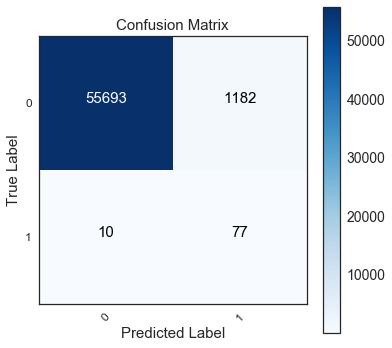

In [66]:
plt.figure(figsize=(6,6))
plt.imshow(cnf_matrix_log_smt, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names_label, rotation=45, fontsize=12)
plt.yticks(tick_marks, class_names_label, fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)


for i in range(len(cnf_matrix_log_smt)):
    for j in range(len(cnf_matrix_log_smt[i])):
        color = 'black'   
        if cnf_matrix_log_smt[i][j] > 2000:
            color = 'white'
        plt.text(j, i, format(cnf_matrix_log_smt[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

Area under the ROC curve: 0.932138


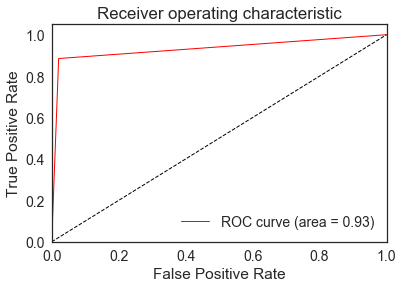

In [65]:
# ROC curve - plot True Positive Rate against False Positive Rate
fpr, tpr, thresholds = roc_curve(y_smt_test, pred_log_smt)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve: %f" % roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [68]:
def run_skfold_SMOTE(X, Y, model):
    
    skf = StratifiedKFold(n_splits=10)
    
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    auc_list = []
    fold = 0
    
    for train_index, test_index in skf.split(X, Y):
        fold += 1
        smt = SMOTE(sampling_strategy = 'minority', random_state = 42)
        # SMOTE happens during cross validation applied ONLY on the training dataset
        X_resampled, y_resampled = smt.fit_sample(X.values[train_index], Y.values[train_index])

        model.fit(X_resampled, y_resampled)
        predictions = model.predict(X.values[test_index])
        
        accuracy = accuracy_score(Y.values[test_index], predictions)
        precision = precision_score(Y.values[test_index], predictions)
        recall = recall_score(Y.values[test_index], predictions)
        f1 = f1_score(Y.values[test_index], predictions)
        auc = roc_auc_score(Y.values[test_index], predictions)
        
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        auc_list.append(auc)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
    
    
    return np.mean(accuracy_list), np.mean(precision_list), np.mean(recall_list), np.mean(f1_list), np.mean(auc_list)


In [69]:
log_model_skFold = LogisticRegression()
acc_log_smt, prec_log_smt, recall_log_smt, f1_log_smt, auc_log_smt = run_skfold_SMOTE(X_orig, y_orig, log_model_skFold)
print("--"*42) 
print("Accuracy: {0}".format(acc_log_smt))  
print("Precision: {0}".format(prec_log_smt))  
print("Recall: {0}".format(recall_log_smt))  
print("F1: {0}".format(f1_log_smt))  
print("AUC: {0}".format(auc_log_smt))  

Fold 1 accuracy: 0.9506688669639409
Fold 2 accuracy: 0.966363540606018
Fold 3 accuracy: 0.9724377655278957
Fold 4 accuracy: 0.9871844387486395
Fold 5 accuracy: 0.9827604367824163
Fold 6 accuracy: 0.9584635370949054
Fold 7 accuracy: 0.9618693163863629
Fold 8 accuracy: 0.9756671348314607
Fold 9 accuracy: 0.9766502808988764
Fold 10 accuracy: 0.9889044943820224
------------------------------------------------------------------------------------
Accuracy: 0.972096981222254
Precision: 0.06162230090707873
Recall: 0.871673469387755
F1: 0.11351792572053969
AUC: 0.9219718328098685


## K-Nearest Neighbour - Oversampling

In [ ]:
# Logistic Regression
kNN_model_SMOTE = KNeighborsClassifier()
kNN_model_SMOTE.fit(X_smt_sampled, y_smt_sampled)
train_score_SMOTE = cross_val_score(kNN_model_SMOTE, X_smt_sampled, y_smt_sampled, cv = 5)
print(train_score_SMOTE.mean()) #training score mean

In [ ]:
pred_knn_smt = kNN_model_SMOTE.predict(X_smt_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_smt_test, pred_knn_smt)*100))

In [ ]:
# Print classification report
print(classification_report(y_smt_test,pred_knn_smt))

In [ ]:
# Get Confusion Matrix
cnf_matrix_knn_smt = confusion_matrix(y_smt_test, pred_knn_smt)

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(cnf_matrix_knn_smt, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names_label, rotation=45, fontsize=12)
plt.yticks(tick_marks, class_names_label, fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)


for i in range(len(cnf_matrix_knn_smt)):
    for j in range(len(cnf_matrix_knn_smt[i])):
        color = 'black'   
        if cnf_matrix_knn_smt[i][j] > 2000:
            color = 'white'
        plt.text(j, i, format(cnf_matrix_knn_smt[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

In [ ]:
# ROC curve - plot True Positive Rate against False Positive Rate
fpr, tpr, thresholds = roc_curve(y_smt_test, pred_knn_smt)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve: %f" % roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
knn_model_skFold = KNeighborsClassifier()
acc_knn_smt, prec_knn_smt, recall_knn_smt, f1_knn_smt, auc_knn_smt = run_skfold_SMOTE(X_orig, y_orig, knn_model_skFold)
print("--"*42) 
print("Accuracy: {0}".format(acc_knn_smt))  
print("Precision: {0}".format(prec_knn_smt))  
print("Recall: {0}".format(recall_knn_smt))  
print("F1: {0}".format(f1_knn_smt))  
print("AUC: {0}".format(auc_knn_smt))  

In [ ]:
# Run kfold on logistic and kNN as well 

# Use one single log regression and split it up into confusion matrix using SMOTE

# Use one singke kNN and split it up into confusion matri using SMOTE

# Then run kfold

# THen compare the two 

# add notes


### Compare logistic regression and KNearestNeighbours for Oversampling

In [ ]:
print("\t\tLogistic Regression\t|\t\tKNN")
print("Accuracy:\t {0}\t|\t{1}".format(acc_log_smt, acc_knn_smt))  
print("Precision:\t {0}\t|\t{1}".format(prec_log_smt, prec_knn_smt))  
print("Recall:\t\t {0}\t|\t{1}".format(recall_log_smt, recall_knn_smt))  
print("F1:\t\t {0}\t|\t{1}".format(f1_log_smt, f1_knn_smt))  
print("AUC:\t\t {0}\t|\t{1}".format(auc_log_smt, auc_knn_smt))  
print("--"*42)